# Optimizing diversified investment portfolios considering cryptocurrencies and other Brazilian financial products, using Markowitz model approach, GARCH models and Genetic algorithms.

*** By Pablo Calvache***

In [1]:
#Imports

from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import certifi
import urllib3
import pycurl
import datetime, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

# Data extraction

Using Python curl and HTML libraries, data from websites containing closing prices of either stocks and cryptocurrencies assets, is extracted and summarized. Such data is public!

** OBS: ** Regardless the Brazilian stocks prices are given in *BRL (Real)* and the crypto prices are given in *USD (American Dolar)*,  transforming from USD to BRL is desnecessary due only differentiated series are considered by Markowitz models. 

## Stock info

Data at this stage, is obtained from Yahoo finance portal because of its HTML structure and easiness at reading.  

In [2]:
# https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1452045600&period2=1515549600&interval=1d&filter=history&frequency=1d
def date_to_seconds(date_string, formatting = '%d-%m-%Y' ):
    t = datetime.strptime(date_string, formatting)
    return int(time.mktime(t.timetuple()))

def get_historical_data(name, init, end):
    data_close_prices, index_date = [], []
    url = "https://br.finance.yahoo.com/quote/{name}/history?period1={init}&period2={end}&interval=1d&filter=history&frequency=1d"\
                .format(name=name, init=str(init), end=str(end))
    print('Downloading from ... '+ url)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    rows = BeautifulSoup(r.data, 'html.parser').findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        #data.append({'date': divs[0].text, 
                    #'open': divs[1].text,
                    #'max': divs[2].text,
                    #'min': divs[3].text,
                    #'close': divs[4].text})
                    
        if len(divs) < 4:
            continue
            
        data_close_prices.append(float(divs[4].text.replace(",", ".")))
        index_date.append(divs[0].text)
    
    key = 'stock_close_'+name.split('.')[0]
    return pd.DataFrame({key:list(reversed(data_close_prices))}, index = list(reversed(index_date)))

def download_portafolio_as_pandas(papers, interval):
    portafolio_pd = pd.DataFrame()
    for paper in papers:
        init_sec = date_to_seconds(interval['init'])
        end_sec = date_to_seconds(interval['end'])
        if portafolio_pd.size == 0:
            portafolio_pd = get_historical_data(paper, init_sec, end_sec)
        else:
            portafolio_pd = portafolio_pd.join(get_historical_data(paper, init_sec, end_sec), how ='left')
    
    return portafolio_pd

In [3]:
# downloading data

papers = ["ABEV3.SA", "ITUB4.SA", "BBDC3.SA", "PETR4.SA", "VALE3.SA", "BSAN33.SA", "ITSA4.SA", 
          "VIVT4.SA", "BBSE3.SA", "CIEL3.SA"]

#"BRSR6.SA","ELET6.SA","CESP6.SA","PCAR4.SA",
#          "CGAS5.SA","CMIG4.SA","CPLE6.SA","ELPL4.SA",

# Yahoo allows to download 100 days only, therefore
time_intervals = [{'init' : '01-07-2018', 'end' : '31-08-2018'},
                  {'init' : '01-04-2018', 'end' : '30-06-2018'},
                  {'init' : '01-01-2018', 'end' : '31-03-2018'},
                  {'init' : '01-10-2017', 'end' : '31-12-2017'},
                  {'init' : '01-07-2017', 'end' : '30-09-2017'},
                  {'init' : '01-04-2017', 'end' : '30-06-2017'},
                  {'init' : '01-01-2017', 'end' : '31-03-2017'}]


stock_prices_pd = pd.DataFrame()
for time_interval in time_intervals:
    if stock_prices_pd.size == 0:
        stock_prices_pd = download_portafolio_as_pandas(papers, time_interval)
    else:
        stock_prices_pd = pd.concat([download_portafolio_as_pandas(papers, time_interval), stock_prices_pd])

#### Formatting Date index

In [4]:
def formating_yahoo_date(date_text):
    date_text = date_text.replace(' de ', '-')
    splitted_date = date_text.split('-')
    day, month_pt, year = splitted_date[0], splitted_date[1], splitted_date[2]
    return {
      'dez': lambda year, day: year + '-' + '12' + '-' + day,
      'nov': lambda year, day: year + '-' + '11' + '-' + day,
      'out': lambda year, day: year + '-' + '10' + '-' + day,
      'set': lambda year, day: year + '-' + '09' + '-' + day,
      'ago': lambda year, day: year + '-' + '08' + '-' + day,
      'jul': lambda year, day: year + '-' + '07' + '-' + day,
      'jun': lambda year, day: year + '-' + '06' + '-' + day,
      'mai': lambda year, day: year + '-' + '05' + '-' + day,
      'abr': lambda year, day: year + '-' + '04' + '-' + day,
      'mar': lambda year, day: year + '-' + '03' + '-' + day,
      'fev': lambda year, day: year + '-' + '02' + '-' + day,
      'jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

stock_prices_pd.index = [formating_yahoo_date(date_yahoo) for date_yahoo in stock_prices_pd.index.values]

In [5]:
stock_prices_pd.tail()

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
2018-08-10,18.91,43.23,25.43,19.59,51.71,19.6,10.01,40.47,23.10,14.12
2018-08-13,19.14,43.57,26.05,20.04,52.28,19.5,9.96,41.08,23.80,14.35
2018-08-14,19.41,44.47,26.41,19.98,52.76,19.3,10.20,41.20,24.39,15.08
2018-08-15,19.42,44.17,26.24,19.05,50.41,19.5,10.18,40.90,25.45,14.81
2018-08-16,19.01,44.11,25.80,18.95,49.72,19.0,10.08,40.47,26.01,14.98


## Croptocurrencies

#### Loading Objects from coinMarket

Due criptocurrencies are harder to trade and exchange, an important criterion in ordet to select the correct ones is the ease in exhancging... 

In [6]:
#date format = 20170817
def formating_coinmarket_date(date_text):
    date_text = date_text.replace(',', '')
    splitted_date = date_text.split(' ')
    day, month_pt, year = splitted_date[1], splitted_date[0], splitted_date[2]
    return {
      'Dec': lambda year, day: year + '-' + '12' + '-' + day,
      'Nov': lambda year, day: year + '-' + '11' + '-' + day,
      'Oct': lambda year, day: year + '-' + '10' + '-' + day,
      'Sep': lambda year, day: year + '-' + '09' + '-' + day,
      'Aug': lambda year, day: year + '-' + '08' + '-' + day,
      'Jul': lambda year, day: year + '-' + '07' + '-' + day,
      'Jun': lambda year, day: year + '-' + '06' + '-' + day,
      'May': lambda year, day: year + '-' + '05' + '-' + day,
      'Apr': lambda year, day: year + '-' + '04' + '-' + day,
      'Mar': lambda year, day: year + '-' + '03' + '-' + day,
      'Feb': lambda year, day: year + '-' + '02' + '-' + day,
      'Jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

def get_values_table(source_path, currency, start_date, end_date):
    url = source_path.format(currency = currency, start_date = start_date, end_date = end_date)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    print('Downloading from ... '+ url)
    r = http.request('GET', url)
    #r = urllib.urlopen(url).read() # Python 2
    soup = BeautifulSoup(r.data, 'html.parser')
    table = soup.find('table')
    data = []
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    df_temp = pd.DataFrame.from_records(list(reversed(data)))
    df_temp.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
   
    close_prices = [float(close) for close in list(df_temp['Close'])]
    df_close = pd.DataFrame({'ccurr_'+currency+'_close' : close_prices}, index = df_temp['Date'])
    
    return df_close

def download_cripto_currencies_close_price_as_pandas(currencies, date_interval):
    source_path = 'https://coinmarketcap.com/currencies/{currency}/historical-data/?start={start_date}&end={end_date}'
    ccurrencies_pd = pd.DataFrame()
    for key, val in currencies.items():
        if ccurrencies_pd.size == 0:
            ccurrencies_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
        else:
            temp_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
            ccurrencies_pd = ccurrencies_pd.join(temp_pd, how ='left')
    
    return ccurrencies_pd

def from_usd_to_pt(currencies_pd, exchange_pd):
    currencies_pd_temp = currencies_pd.join(exchange_pd, how='inner')
    return cripto_currencies_pd.transform(lambda x: x * currencies_pd_temp['close_price_usd_pt'])

In [7]:
currencies = {'bitcoin' : 'bitcoin', 
              'ethereum' : 'ethereum', 
              'bitcoin_cash' : 'bitcoin-cash', 
              'litecoin' : 'litecoin',
              'ripple' : 'ripple',
              'NEO' : 'neo',
              'stellar': 'stellar',
              'monero' : 'monero',
              'EOS' : 'eos',
              'dash' : 'dash'}

# 'IOTA' : 'iota',

date_interval = {'init': '2017-01-01', 'end' : '2018-07-31' }

cripto_currencies_pd = download_cripto_currencies_close_price_as_pandas(currencies, date_interval)
cripto_currencies_pd.index =[formating_coinmarket_date(date_coinm) for date_coinm in cripto_currencies_pd.index.values]
#cripto_currencies_pd = from_usd_to_pt(cripto_currencies_pd, usd_br_pd)

In [8]:
# trabajar con coingecko - op 1
# 
cripto_currencies_pd

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
2017-01-01,998.33,8.17,NaN,4.51,0.006368,0.141841,0.002481,13.97,NaN,11.23
2017-01-02,1021.75,8.38,NaN,4.65,0.006311,0.145642,0.002477,16.05,NaN,11.81
2017-01-03,1043.84,9.73,NaN,4.63,0.006386,0.140422,0.002554,16.09,NaN,12.78
2017-01-04,1154.73,11.25,NaN,4.84,0.006570,0.136734,0.002735,18.53,NaN,16.52
2017-01-05,1013.38,10.25,NaN,4.29,0.006201,0.131070,0.002598,16.19,NaN,14.38
2017-01-06,902.20,10.25,NaN,3.86,0.006315,0.135472,0.002494,14.03,NaN,12.03
2017-01-07,908.59,9.87,NaN,3.96,0.006366,0.131104,0.002396,13.06,NaN,12.44
2017-01-08,911.20,10.29,NaN,3.99,0.006233,0.132609,0.002355,13.47,NaN,12.54
2017-01-09,902.83,10.33,NaN,4.30,0.006167,0.123767,0.002347,13.74,NaN,12.09
2017-01-10,907.68,10.55,NaN,4.59,0.006698,0.133864,0.002355,13.39,NaN,12.49


## Preprocessing, financial time series theory

In order to avoid biases caused by sporious correlations and not stationary trends a and variance, the original 'closing price' series of each asset, a derivation and logaritmic scale transformation is performed in order to make the series stationary in trend and variance. Such method delivers the data in a format compatible with the Markowitz model input, and such transformations also are kind of standar in finance analyisis.

In [9]:
# Rt - returns
def get_returns_in_percent(pd_dataframee):
    return (pd_dataframee.diff() / pd_dataframee.shift(periods=1))

# rt - rate returns
def get_rate_return(pd_dataframe):
    pd_temp = np.log(pd_dataframe)
    return pd_temp.diff()

** Non stationary Time Series **

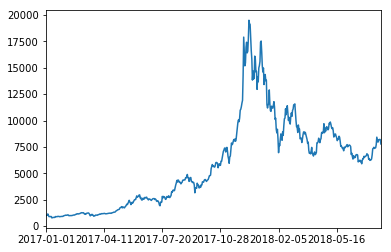

In [10]:
cripto_currencies_pd['ccurr_bitcoin_close'].plot()

** *Diff* or First order Derived Series: Making the series stationary in trend**

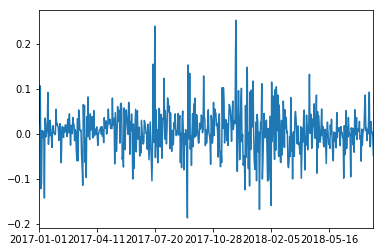

In [11]:
get_returns_in_percent(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

**Most of the time series models works with $r_t$ (spin term??) rather than $R_t$. So by applying the $r_t$ function defined above, we obtain:**

In [12]:
get_returns_in_percent(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023459,0.025704,NaN,0.031042,-0.008951,0.026798,-0.001612,0.14889,NaN,0.051647


In [13]:
get_rate_return(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023188,0.025379,NaN,0.03057,-0.008991,0.026445,-0.001614,0.138797,NaN,0.050358


**OBS:** Despite the similarity in the plots above, returns and return rates are sighlty different from each other. 

** Checking the time series distribution, we get a normal distribution **

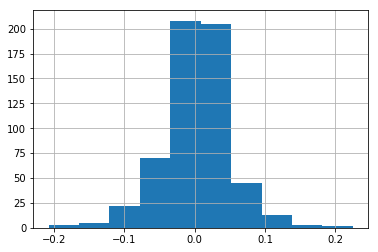

In [14]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].hist()

### Merging Data and filling NaN values

NaN values are in the dataframe due several assets (some cryptocurrencies mainly) have not got a long track closing price history. Such as the case with Cardano and Bit Coin Cash, the first one mentioned for instance has history starting from 13-10-2017 only, hence it is assumed there was not any variance in closing prices difference percent (already differentiated series) before that point filling such missing values with 0. This applies also for None values along the data.

In [15]:
# Stocks percent returns
percent_stocks_returns = get_returns_in_percent(stock_prices_pd)
# remmoving duplicated indexes
percent_stocks_returns = percent_stocks_returns[~percent_stocks_returns.index.duplicated(keep='first')]
percent_stocks_returns = percent_stocks_returns.fillna(0)
stock_return_rates = get_rate_return(stock_prices_pd)
stock_return_rates = stock_return_rates.fillna(0)

# Criptocurrencies percent returns
percent_cripto_returns = get_rate_return(cripto_currencies_pd)
# remmoving duplicated indexes
percent_cripto_returns = percent_cripto_returns[~percent_cripto_returns.index.duplicated(keep='first')]
percent_cripto_returns = percent_cripto_returns.fillna(0)
ccurr_return_rates = get_rate_return(cripto_currencies_pd)
ccurr_return_rates = ccurr_return_rates.fillna(0)

# Merged DF
portafolio_pd = stock_prices_pd.join(cripto_currencies_pd, how = 'inner')
percent_returns_pd = get_rate_return(portafolio_pd)
# remmoving duplicated indexes
percent_returns_pd = percent_returns_pd[~percent_returns_pd.index.duplicated(keep='first')]
percent_returns_pd = percent_returns_pd.fillna(0)
return_rates_pd = get_rate_return(portafolio_pd)
return_rates_pd = return_rates_pd.fillna(0)

### Augmented Dickey fueller test

In [16]:
from statsmodels.tsa.stattools import adfuller

dickey_outcome = return_rates_pd.apply(lambda col: adfuller(col)[0])
dickey_outcome

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


stock_close_ABEV3          -19.724147
stock_close_ITUB4          -21.201347
stock_close_BBDC3          -21.535764
stock_close_PETR4           -5.116427
stock_close_VALE3          -14.770932
stock_close_BSAN33         -12.610439
stock_close_ITSA4          -13.163923
stock_close_VIVT4          -16.885107
stock_close_BBSE3          -12.067777
stock_close_CIEL3          -14.215063
ccurr_bitcoin_close        -19.209836
ccurr_ethereum_close       -17.855852
ccurr_bitcoin-cash_close    -6.104374
ccurr_litecoin_close        -4.887639
ccurr_ripple_close         -10.840650
ccurr_neo_close            -20.950824
ccurr_stellar_close        -17.672046
ccurr_monero_close         -21.108018
ccurr_eos_close             -4.122156
ccurr_dash_close           -12.630605
dtype: float64

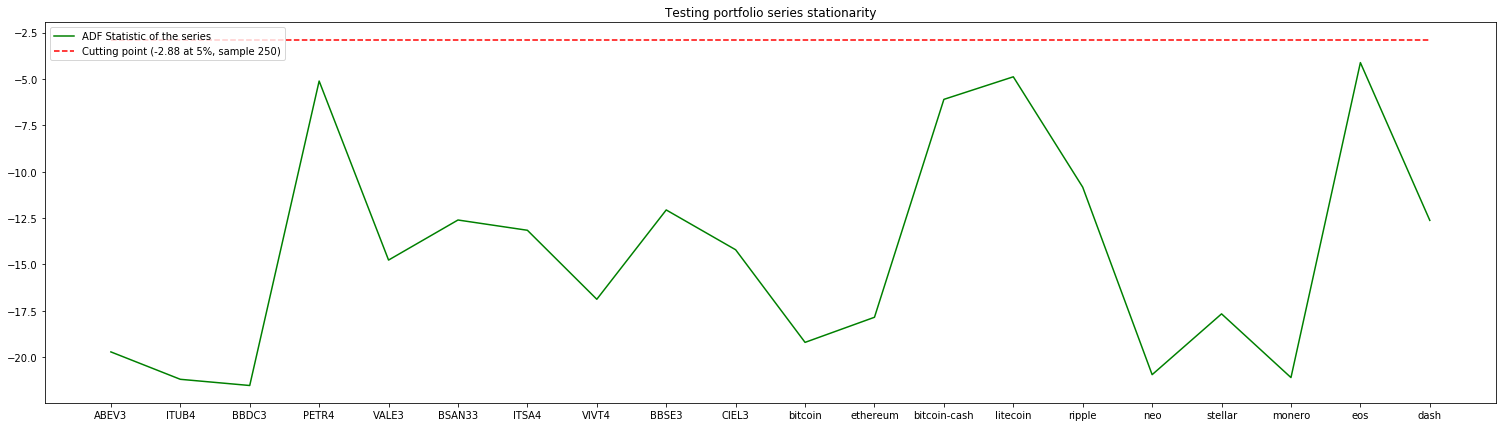

In [17]:
plt.figure(figsize=(26,7))
x_lab = [index.replace('stock','').replace('ccurr','').replace('close', '').replace('_','') for index in dickey_outcome.index]
plt.xticks(range(len(dickey_outcome.values)), x_lab) 
plt.plot(dickey_outcome.values,label='ADF Statistic of the series',color='green')
plt.plot(np.full((1, len(dickey_outcome.values)), -2.88)[0],'k--',label='Cutting point (-2.88 at 5%, sample 250)',color='red')
plt.title('Testing portfolio series stationarity')
plt.legend(loc='upper left')
plt.show()

# Descriptive analysis


**Negative correlation between sotck and cryptocurrencies markets**: 


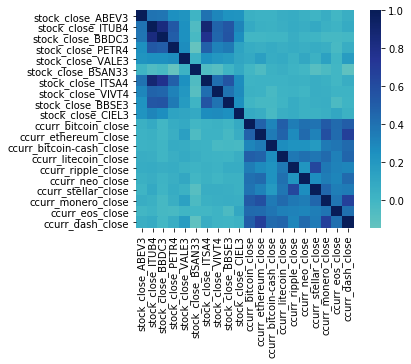

In [18]:
## Pearson correlation - All portafolio
sns.heatmap(percent_returns_pd.tail(360).corr(method='pearson'),  cmap="YlGnBu", center=0, square=True)

The behaviour described in the hypthotesis above, is showed in the data as well, menaning it works also for Brazilian stock assets.

## GARCH models - Getting return value of an asset by using 

**OBS: ** Whenever a GARCH Model does not converge, it is used the mean of the series instead considering the recomendations given by some literature regarding the subject, such as (dell course).
"when the data is to messy or may not be able to fit a medium/high complexity model, working with the expected value or mean turns out a better option".

In [19]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

from arch import arch_model

def fit_garch(TS, p_range = 3, o_range = 0, q_range = 3, dist = "StudentsT"):
    dict_temp = {}
    best_aic = None
    best_order = None
    best_model = None
    for p in range(p_range+1):
        for o in range(o_range+1):
            for q in range(q_range+1):
                try:
                    am = arch_model(TS, p=p, o=o, q=q, dist = 'StudentsT')
                    res = am.fit(update_freq=5, disp='off')
                    tmp_aic = res.aic

                    if best_aic is None:
                        best_aic = tmp_aic
                    if tmp_aic <= best_aic:
                        dict_temp = {'best_aic' : tmp_aic, 'model': am, 'results' : res.forecast().mean.iloc[-1]}
                except:
                    if 'best_aic' not in dict_temp:
                        dict_temp = {'best_aic' : 9999999, 'results' : TS.mean() }
                    continue
    return dict_temp


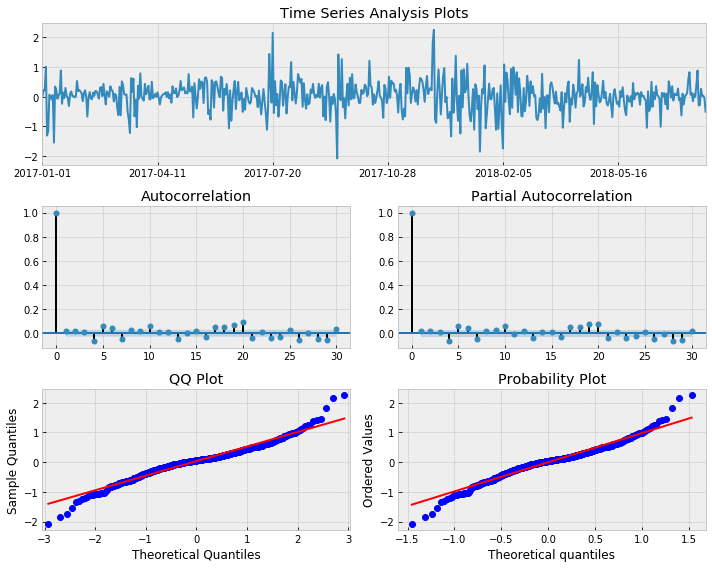

In [20]:
tsplot(np.multiply(ccurr_return_rates['ccurr_bitcoin_close'], 10), lags = 30)

In [21]:
am = arch_model(np.multiply(ccurr_return_rates['ccurr_bitcoin_close'], 10), mean='AR',p=7, o=0, q=7, dist = 'StudentsT')
res = am.fit(update_freq=5, disp='off')
res

                              AR - GARCH Model Results                              
Dep. Variable:          ccurr_bitcoin_close   R-squared:                      -0.003
Mean Model:                              AR   Adj. R-squared:                 -0.003
Vol Model:                            GARCH   Log-Likelihood:               -340.677
Distribution:      Standardized Student's t   AIC:                           715.355
Method:                  Maximum Likelihood   BIC:                           789.438
                                              No. Observations:                  577
Date:                      Fri, Aug 17 2018   Df Residuals:                      560
Time:                              00:01:55   Df Model:                           17
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Cons

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

                        Constant Mean - GARCH Model Results                         
Dep. Variable:          ccurr_bitcoin_close   R-squared:                      -0.003
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                            GARCH   Log-Likelihood:                983.449
Distribution:      Standardized Student's t   AIC:                          -1948.90
Method:                  Maximum Likelihood   BIC:                          -1909.68
                                              No. Observations:                  577
Date:                      Fri, Aug 17 2018   Df Residuals:                      568
Time:                              00:01:56   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

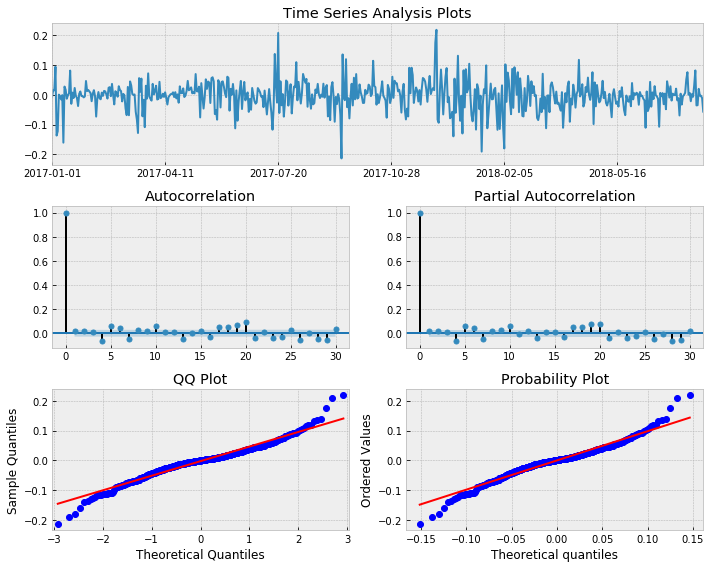

In [22]:
model_sample = fit_garch(ccurr_return_rates['ccurr_bitcoin_close'])
res = model_sample['model'].fit(update_freq=5, disp='off')
print(res)
tsplot(res.resid, lags = 30)


** Predicting the returns **

In [23]:
# Testing
test_returned = ccurr_return_rates[145: 175].apply(lambda col: fit_garch(col)['results'])
test_returned

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encou

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
h.1,0.004045,0.003822,0.0,0.006162,-0.010336,0.020073,0.001956,0.003072,0.0,0.014683


Considering expression: 

$$ R_t = {e^{r_t}} - 1 $$

In [24]:
# Slighlty different from the previous one, but different anyway
test_returned.apply(lambda col: (np.exp(col) - 1))

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
h.1,0.004054,0.003829,0.0,0.006181,-0.010283,0.020276,0.001957,0.003077,0.0,0.014791


# Limitations

As the criteria for analysing a good fitted model are ausually graplhical, automate a GARCH model the best way possible is difficult.

## Drawing Markowitz efficient frontier


### OBS:

When simulating with genetic algorithims, there is a possibility of some portafolios may not match pre-fixed risk value. Furthemore there is a chance than a portafolio with a very close risk of any of the pre-fixed ones, may have a higher return value.

In order to minimize the effect of such issues, the efficient Markowithz frontier is going to be composed by the portafolios with the maximum return within an interval of +- 0.1 per each risk pre-fixed risk point. 

In [25]:
def return_risk_interval(df, number_of_steps = 5): 
    max_return = df.loc[df['return'] == df['return'].max()]
    min_risk = df.loc[df['risk'] == df['risk'].min()]

    delta = (max_return.iloc[0]['risk'] - min_risk.iloc[0]['risk']) / float(number_of_steps)
    if delta == 0:
        delta = 0.00001
    steps = list()

    for i in list(range(0,number_of_steps + 1)):
        if i == 0:
            steps.append(min_risk.iloc[0]['risk'])
        else:
            steps.append(steps[i-1] + delta)

    return [tuple([i-(delta*0.45), i+(delta*0.45)]) for i in steps] # 0,45 * delta guaranties interval overlapping does not Occur  

def drawing_frontier(df):
    steps_risk_interval = return_risk_interval(df)
    frontier = pd.DataFrame()
    for interval in steps_risk_interval:
        sliced_df = df.loc[(df['risk'] > interval[0])&(df['risk'] < interval[1])]

        if len(sliced_df) == 0: # If this condition is True, means for such interval, does not exist a solution.
            continue
            
        max_return_in_interval = max(sliced_df['return'])
        optimal_interval_portafolio = df.loc[df['return'] == max_return_in_interval].iloc[[0]]
        frontier = pd.concat([frontier, optimal_interval_portafolio])
    
    return frontier

# Call to execute
#frontier = drawing_frontier(df_ga_stock_output)  
#sns.lmplot(x="risk", y="distribution_return", data=frontier, fit_reg=True)


### Ratio of sharpe methods

In [26]:
def get_free_risk_asset_return(annual_rate=0.4, investment_period_in_days=30):
    daily_rate = (1.0+annual_rate)**(1.0/360.0) - 1.0
    free_risk_asset_return = 1
    for i in range(0, investment_period_in_days):
        free_risk_asset_return = free_risk_asset_return + (free_risk_asset_return * daily_rate)
        
    return free_risk_asset_return - 1
    
    
# Ratio of sharpe
def get_ratio_of_sharpe(weights, input_df, free_risk_asset_return):
    
    returns_portafolio = input_df.mean().dot(weights)
    std_portafolio = input_df.cov().dot(weights).dot(weights) ** 0.5

    return (returns_portafolio - free_risk_asset_return) / std_portafolio

## Random simulations - Workflow Example

A random simulation sets random values to the weights according to a given ditribution, gaussian mainly.

In [27]:
# test
def get_train_test_data(pd_dataframe, train_data_size):
    df_size = len(pd_dataframe.index)
    return pd_dataframe[0:df_size*train_data_size], pd_dataframe[df_size*train_data_size, df_size]

# Objective function using means for calculating returns
def random_simulations(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_mean = return_df.mean() # Optimizes the process by calculating this just once
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_mean.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Objective function using GARCH for calculating returns
def random_simulations_using_garch(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_predict = return_rate_df.apply(lambda col: fit_garch(col)['results']) # Optimizes the process by calculating this just once
    returns_predict = returns_predict.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_predict.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Simulate portfolios method
def simulate_portafolios(function, lag = 0, window_time = 60, n = 1000):
    
    tail = len(percent_returns_pd.index)
    
    # Stocks only portafolio
    map_test = function(percent_stocks_returns[tail - (lag + window_time): tail - lag], 
                        stock_return_rates[tail - (lag + window_time): tail - lag],
                        n)
    print('stocks.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_stock_df = pd.DataFrame(map_test)
    simulations_stock_df['portafolio_type'] = ['stock_only' for i in simulations_stock_df.index]

    # Criptocurrencies only portafolio
    map_test = function(percent_cripto_returns[tail - (lag + window_time): tail - lag], 
                        ccurr_return_rates[tail - (lag + window_time): tail - lag], 
                        n)
    print('ccurr.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_ccur_df = pd.DataFrame(map_test)
    simulations_ccur_df['portafolio_type'] = ['ccurr_only' for i in simulations_ccur_df.index]

    # Total portafolio
    map_test = function(percent_returns_pd[tail - (lag + window_time): tail - lag],
                        return_rates_pd[tail - (lag + window_time): tail - lag],
                        n)
    print('mixed.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_df = pd.DataFrame(map_test)
    simulations_df['portafolio_type'] = ['mixed_assets' for i in simulations_df.index]
    
    return simulations_stock_df, simulations_ccur_df, simulations_df


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

stocks.. init: 310 end: 340
ccurr.. init: 310 end: 340


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

mixed.. init: 310 end: 340


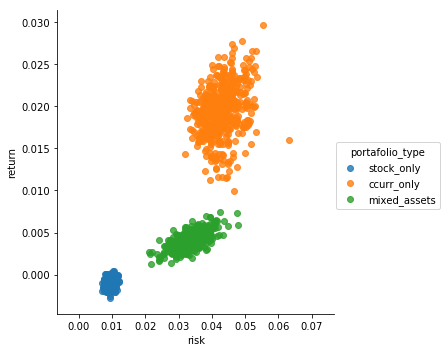

In [28]:
# Simulating Portfolios 
lag, window_time = 60, 30

# With mean
#simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations, lag, window_time,500)

# With Garch
simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations_using_garch, lag, window_time,500)

simulation_frames = [simulations_stock_df, simulations_ccur_df, simulations_df]
simulations_concatenated = pd.concat(simulation_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

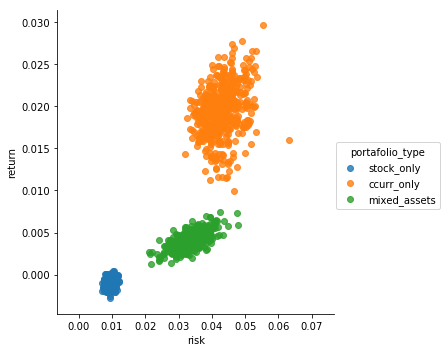

In [29]:
sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

*** Drawing Markowitz efficient frontier ***

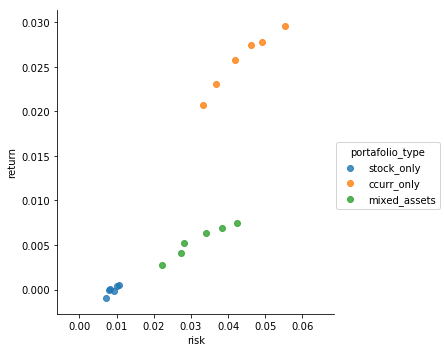

In [30]:
stock_frontier = drawing_frontier(simulations_stock_df)
ccur_frontier = drawing_frontier(simulations_ccur_df)
mixed_frontier = drawing_frontier(simulations_df)

summarized_frontiers = [stock_frontier, ccur_frontier, mixed_frontier]
summarized_frontiers = pd.concat(summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_frontiers, fit_reg=False)

In [31]:
stock_frontier

,assets,index,return,risk,weights,portafolio_type
281,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",281,-0.000965,0.007121,"[0.0147748933257, 0.0206895448056, 0.055647824...",stock_only
214,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",214,0.000013,0.007863,"[0.195139721696, 0.153220889955, 0.00026792048...",stock_only
158,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",158,0.000100,0.008327,"[0.0694725587078, 0.124155313562, 0.0201592413...",stock_only
294,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",294,-0.000108,0.009249,"[0.138708392596, 0.104788468067, 0.05657498725...",stock_only
280,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",280,0.000414,0.010245,"[0.179929666225, 0.0155162889462, 0.0250333894...",stock_only
251,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",251,0.000485,0.010650,"[0.156839234926, 0.10409324939, 0.000873737583...",stock_only


*** Ratio of Sharpe ***

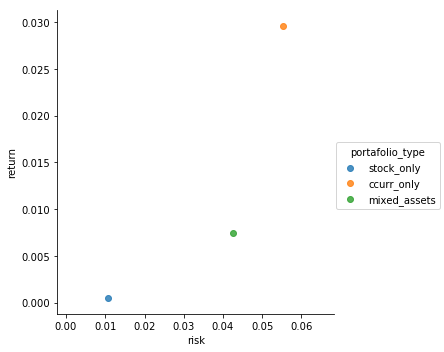

In [32]:
free_risk_asset = get_free_risk_asset_return(0.4, window_time)

# Calcuating ratio of sharpe of each asset belonging to the markwitz frontier

stock_frontier['ratio_of_sharpe'] = stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, free_risk_asset) , axis = 1)
ccur_frontier['ratio_of_sharpe'] = ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, free_risk_asset) , axis = 1)
mixed_frontier['ratio_of_sharpe'] = mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, free_risk_asset) , axis = 1)


# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = stock_frontier.loc[stock_frontier['ratio_of_sharpe'] == max(stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ccur_frontier.loc[ccur_frontier['ratio_of_sharpe'] == max(ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  mixed_frontier.loc[mixed_frontier['ratio_of_sharpe'] == max(mixed_frontier['ratio_of_sharpe'])]

# Ploting
summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

# Genetic Algorithms

***OBS: *** Few data with a linear Opt. Function (substraction) tend to fall in local "maximus" (higher probabiity of exploit). Whereas a non-linear F.O. apparently does not.

### GA functions declaration

In [51]:
'''
@article{DEAP_JMLR2012, 
    author    = " F\'elix-Antoine Fortin and Fran\c{c}ois-Michel {De Rainville} and Marc-Andr\'e Gardner and Marc Parizeau and Christian Gagn\'e ",
    title     = { {DEAP}: Evolutionary Algorithms Made Easy },
    pages    = { 2171--2175 },
    volume    = { 13 },
    month     = { jul },
    year      = { 2012 },
    journal   = { Journal of Machine Learning Research }
'''

############### GA Implementation #############

def run_ga(percent_returns_pd, rate_returns_pd, use_garch = False):
    
    from deap import creator, base, tools, algorithms
    
    #Selecting which method should be used for calculating the returns by asset 
    if use_garch is False:
        returns = percent_returns_pd.mean()
        returns_cov = percent_returns_pd.cov()
    else:
        returns = rate_returns_pd.apply(lambda col: fit_garch(col)['results'])
        returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
        returns_cov = percent_returns_pd.cov()
    
    # Objective function
    def objective_function(individual):
        if sum(individual) == 0:
            total = 1e-3
        else:
            total = sum(individual)
        w = np.divide(individual, total)
        return_portafolio = returns.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        if std_portafolio == 0:
            std_portafolio = 1e-4
        return (return_portafolio - std_portafolio,) 
    
    # Test minimuzing risk only
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    num_assets = len(percent_returns_pd.columns)
    toolbox = base.Toolbox()
    toolbox.register("attr_flt", random.uniform, 0.001, 0.999)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_flt, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", objective_function)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutGaussian)
    toolbox.register("select", tools.selRoulette)
    
    population = toolbox.population(n=500)
    hof = tools.HallOfFame(1)
    
    # Run GA
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    top10 = tools.selBest(population, k=10)
    return pop, returns, returns_cov


############ Outputs processing ##############


def get_portafolio_stats_using_garch(predicted_ret_garch, predicted_ret_garch_cov, optimal_percentuals):    
    return_in_percent = predicted_ret_garch.dot(optimal_percentuals)
    risk_in_percent = predicted_ret_garch_cov.dot(optimal_percentuals).dot(optimal_percentuals) ** 0.5
    return return_in_percent, risk_in_percent, optimal_percentuals

## GA optimization - Workflow Example

***OBS:*** Experiments regarding the optimal number of assets are out of the scope of this work. Such number is defined by the premises adopted since the beginning. 
Considering the most signifcant companies/criptocurrencies according of its size. Companies with a minimum of 80% percent of summarized market capital.


In [52]:
def execute_by_interval(lag = 0, window_time = 30, is_garch = False):    
    
    tail = len(percent_returns_pd.index)
    print('##DF LAG####', tail - (lag + window_time), tail - lag)
    # Stock only
    pop_stock, returns_stock, returns_cov_stock = run_ga(percent_stocks_returns[tail - (lag + window_time): tail - lag],
                                                           stock_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_stock:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_stock,
                                                      returns_cov_stock, 
                                                      pop))
    df_ga_stock_output = pd.DataFrame.from_records(stats) 
    df_ga_stock_output.columns = ['return', 'risk', 'weights']
    df_ga_stock_output['portafolio_type'] = ['stock_only' for i in df_ga_stock_output.index]

    # Cripto Currencies only
    pop_ccurr, returns_ccurr, returns_cov_ccurr = run_ga(percent_cripto_returns[tail - (lag + window_time): tail - lag],
                                                           ccurr_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_ccurr:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_ccurr,
                                                      returns_cov_ccurr,
                                                      pop))
    df_ga_ccur_output = pd.DataFrame.from_records(stats) 
    df_ga_ccur_output.columns = ['return', 'risk', 'weights']
    df_ga_ccur_output['portafolio_type'] = ['ccurr_only' for i in df_ga_ccur_output.index]
    
    # mixed 
    pop, returns_mix, returns_cov_mix = run_ga(percent_returns_pd[tail - (lag + window_time): tail - lag],
                                   return_rates_pd[tail - (lag + window_time): tail - lag],
                                   is_garch)
    print('#### mix returns ###' , returns_mix)
    stats = []
    for individual in pop:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_mix,
                                                      returns_cov_mix,
                                                      pop))
    df_ga_output = pd.DataFrame.from_records(stats) 
    df_ga_output.columns = ['return', 'risk', 'weights']
    df_ga_output['portafolio_type'] = ['mixed_assets' for i in df_ga_output.index]
    
    return df_ga_stock_output.dropna(), df_ga_ccur_output.dropna(), df_ga_output.dropna()

In [53]:
# Exectuing optimization using means with returns

# Using mean for returns    
#df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, False)

# Using Garch for returns
df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(30,30, True)

##DF LAG#### 340 370


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0192006	0.00204961	-0.0266178	-0.0137162


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


TypeError: mutGaussian() missing 3 required positional arguments: 'mu', 'sigma', and 'indpb'

In [ ]:
simulation_ga_frames = [df_ga_stock_output, df_ga_ccur_output, df_ga_output]
simulations_ga_concatenated = pd.concat(simulation_ga_frames)



In [ ]:
sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_ga_concatenated, fit_reg=False)

In [75]:
ga_stock_frontier = drawing_frontier(df_ga_stock_output)
ga_ccur_frontier = drawing_frontier(df_ga_ccur_output)
ga_mixed_frontier = drawing_frontier(df_ga_output)

pre_fixed_time_window = 5
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = ga_stock_frontier.loc[ga_stock_frontier['ratio_of_sharpe'] == max(ga_stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ga_ccur_frontier.loc[ga_ccur_frontier['ratio_of_sharpe'] == max(ga_ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  ga_mixed_frontier.loc[ga_mixed_frontier['ratio_of_sharpe'] == max(ga_mixed_frontier['ratio_of_sharpe'])]


ga_summarized_frontiers = [ga_stock_frontier, ga_ccur_frontier, ga_mixed_frontier]
ga_summarized_frontiers = pd.concat(ga_summarized_frontiers)

summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

In [ ]:
######

In [40]:
w = df_ga_output[df_ga_output['return'] == df_ga_output['return'].max()]['weights'][0]
# izzz modelo esta pifiando

In [41]:
tail = len(return_rates_pd['ccurr_bitcoin_close'])
return_rates_pd[340:370]

returns = return_rates_pd[340:370].apply(lambda col: fit_garch(col)['results'])
returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
returns_cov = return_rates_pd[340:370].cov()

return_portafolio = returns.dot(w)
std_portafolio = returns_cov.dot(w).dot(w) ** 0.5

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

In [42]:
print(return_portafolio)

17.0022257389


In [ ]:
#####

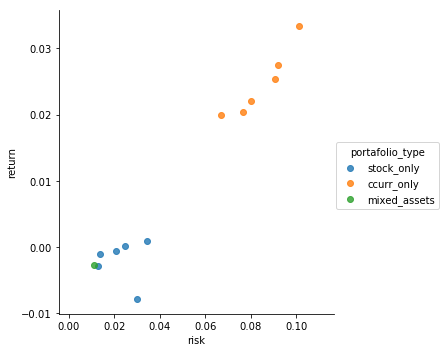

In [76]:
sns.lmplot(x="risk", y="return",hue="portafolio_type", data=ga_summarized_frontiers, fit_reg=False)

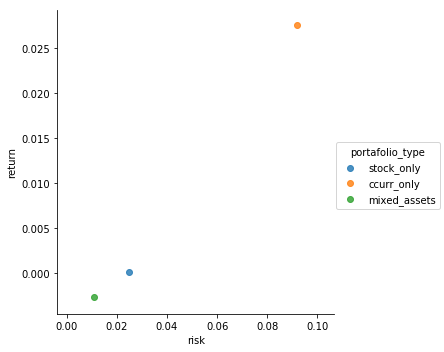

In [77]:
sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

### GA optimization vs Random Simulations

* Looking at the outcome plots of GA and Random simulation respectevaly, the main difference between these both is that GA allows a higher degree of the hyperspace exploration (Hyperspace is defined as the space where the possible silution are located), hence in GA the degree of exploting is lower, which enhaces the searching for global maximums.

* This might not be the case, but for portfolios composed by a signifacnlty higher number of assets, a random simulation dynamic is not suitable due this is considered a NP problem (not polynomial complexity problem in execution time).

## Optimizations(t) 

Once the optmization model is explained, the goal goes towards evaluate the protfolios behaviour in time.


** GA displacing time_window: ** It seeks to evaluate temporal behaviour considering a prefixed time_window displacing lags

In [42]:
tempos = dict()
num_iterations = 3

# Initialy we consider the lag per iteration with the same value of pre_fixed_time_window
lag_step_size, pre_fixed_time_window = 30, 30

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

last_date = percent_returns_pd.index[-1]

for i in range(1,num_iterations+1):
    print((num_iterations-i)*lag_step_size, pre_fixed_time_window)
    df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval((num_iterations-i)*lag_step_size, pre_fixed_time_window, True)
    ga_stock_frontier,ga_ccur_frontier,ga_mixed_frontier = drawing_frontier(df_ga_stock_output), drawing_frontier(df_ga_ccur_output), drawing_frontier(df_ga_output)
   
    ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
    ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
    ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)
    
    partition_date = (datetime.strptime(last_date, '%Y-%m-%d') + relativedelta(days = -((num_iterations-i)*lag_step_size))).strftime('%Y-%m-%d')
    tempos[partition_date] = dict()
    tempos[partition_date]['stock_frontier'] = ga_stock_frontier
    tempos[partition_date]['ccur_frontier'] = ga_ccur_frontier
    tempos[partition_date]['mixed_frontier'] = ga_mixed_frontier

60 30
##DF LAG#### 310 340


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. Th

gen	nevals	avg       	std        	min       	max        
0  	500   	-0.0102748	0.000976139	-0.0131711	-0.00787733
1  	296   	-0.00963178	0.00102265 	-0.0162948	-0.00755828
2  	312   	-0.00913714	0.00100981 	-0.0153131	-0.00714187
3  	292   	-0.00863817	0.000931031	-0.0137288	-0.00693025
4  	300   	-0.00822989	0.000964768	-0.0151029	-0.00684639
5  	300   	-0.00792509	0.00102214 	-0.0147346	-0.0065828 
6  	313   	-0.00783717	0.00142666 	-0.018407 	-0.00648218
7  	310   	-0.00767384	0.0014182  	-0.0166448	-0.00647939
8  	311   	-0.00747935	0.00140101 	-0.0197291	-0.00647939
9  	298   	-0.00735975	0.00150848 	-0.0175289	-0.00647939
10 	291   	-0.00730697	0.00153344 	-0.0173865	-0.00646654
11 	291   	-0.00717807	0.00149252 	-0.0159047	-0.00646654
12 	322   	-0.00730122	0.00174389 	-0.0189847	-0.00646407
13 	312   	-0.00741331	0.00208915 	-0.0191744	-0.00646376
14 	300   	-0.00740933	0.00184976 	-0.015572 	-0.00646376
15 	320   	-0.00741301	0.00199267 	-0.0190943	-0.00645548
16 	266   	-0.00

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std       	min       	max       
0  	500   	-0.023264	0.00460526	-0.0364839	-0.0105021
1  	286   	-0.0205134	0.00521241	-0.071864 	-0.0102001
2  	277   	-0.0182629	0.00515618	-0.0627318	-0.00869615
3  	279   	-0.0165045	0.00550609	-0.0589044	-0.0085737 
4  	293   	-0.0146668	0.00512245	-0.0485557	-0.00676731
5  	315   	-0.0137799	0.006629  	-0.0772993	-0.00676731
6  	306   	-0.0127304	0.00578451	-0.0525182	-0.00676731
7  	304   	-0.0118628	0.00827115	-0.139989 	-0.00660441
8  	304   	-0.0113503	0.00674257	-0.0512628	-0.00630206
9  	319   	-0.01079  	0.00721115	-0.0725308	-0.0062741 
10 	285   	-0.0107584	0.00739132	-0.0600499	-0.00595784
11 	314   	-0.0106013	0.00781073	-0.0528892	-0.0056451 
12 	291   	-0.0100305	0.00842759	-0.0929032	-0.00562822
13 	281   	-0.00924309	0.00693546	-0.0436165	-0.00548752
14 	324   	-0.00941241	0.00834298	-0.0755842	-0.00541019
15 	296   	-0.00977227	0.00933866	-0.0690513	-0.00540061
16 	320   	-0.00935985	0.010063  	-0.140779 	-0.00

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max      
0  	500   	-0.0294499	0.00347487	-0.0421893	-0.016182
1  	318   	-0.0267426	0.00346272	-0.0413741	-0.0126244
2  	325   	-0.0242968	0.00351991	-0.0435002	-0.0126244
3  	293   	-0.0219995	0.00371474	-0.0396431	-0.0119488
4  	319   	-0.0200163	0.00454034	-0.0555828	-0.0101494
5  	318   	-0.018224 	0.00466024	-0.0494489	-0.00951121
6  	318   	-0.0168865	0.00533695	-0.0574172	-0.00856217
7  	283   	-0.0152904	0.00523242	-0.0413499	-0.00856217
8  	280   	-0.0139303	0.00555307	-0.041371 	-0.00803638
9  	294   	-0.0129067	0.0056477 	-0.0378698	-0.00742577
10 	287   	-0.0130669	0.00697191	-0.0479766	-0.00769077
11 	307   	-0.0124258	0.0070884 	-0.0441678	-0.00744098
12 	286   	-0.0114006	0.00681438	-0.0411796	-0.00735034
13 	302   	-0.0113443	0.00706779	-0.0395078	-0.00707761
14 	285   	-0.0110209	0.00718168	-0.0458732	-0.00693778
15 	286   	-0.0112965	0.00772485	-0.0407517	-0.00681761
16 	292   	-0.0110752	0.007791  	-0.0569697	-0.00687977


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min      	max       
0  	500   	-0.0191061	0.00205974	-0.026689	-0.0142487
1  	283   	-0.0178407	0.00240769	-0.0466933	-0.0136054
2  	288   	-0.0167188	0.00181641	-0.0344046	-0.0133044
3  	314   	-0.0159827	0.00168623	-0.0273811	-0.0130695
4  	291   	-0.0154016	0.00172835	-0.0295959	-0.0130695
5  	306   	-0.0148314	0.00157026	-0.0239389	-0.0130002
6  	288   	-0.0145435	0.00194901	-0.0342785	-0.0127668
7  	311   	-0.0142318	0.00207968	-0.0416586	-0.0122137
8  	307   	-0.0141566	0.00200487	-0.0287017	-0.0122137
9  	298   	-0.0140592	0.00222264	-0.0284393	-0.0122137
10 	280   	-0.0138722	0.00217771	-0.0264205	-0.0122137
11 	317   	-0.0137258	0.00211765	-0.0293368	-0.0122137
12 	311   	-0.0136066	0.00214052	-0.0260252	-0.0122137
13 	291   	-0.0134286	0.00246786	-0.0508337	-0.0121844
14 	287   	-0.0134357	0.0022595 	-0.0267193	-0.0121577
15 	300   	-0.0132123	0.00202454	-0.0258329	-0.0121577
16 	291   	-0.0132216	0.00233397	-0.0279432	-0.0121577
17 	319   	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0615811	0.00367366	-0.0776139	-0.0515289
1  	290   	-0.0594331	0.0039412 	-0.0841214	-0.0500009
2  	301   	-0.0571984	0.00414794	-0.0881324	-0.0494699
3  	293   	-0.0558911	0.00406811	-0.0816313	-0.0492823
4  	327   	-0.0545417	0.00465799	-0.0929571	-0.047874 
5  	310   	-0.0531888	0.0046768 	-0.0939233	-0.0473393
6  	290   	-0.0524353	0.00620516	-0.102692 	-0.0469962
7  	286   	-0.0515615	0.00558875	-0.0935092	-0.0464584
8  	290   	-0.05082  	0.00602978	-0.096222 	-0.0464172
9  	316   	-0.0503876	0.0065167 	-0.0977404	-0.0461737
10 	284   	-0.049647 	0.00586626	-0.0932629	-0.0458673
11 	329   	-0.0491127	0.00549739	-0.086851 	-0.0457734
12 	292   	-0.048872 	0.00633806	-0.0945571	-0.0457485
13 	295   	-0.049335 	0.00791823	-0.110006 	-0.0456388
14 	310   	-0.0484782	0.00598007	-0.0810935	-0.0456354
15 	307   	-0.0491844	0.0078292 	-0.121096 	-0.0456345
16 	280   	-0.0485116	0.0076673 	-0.101221 	-0.0456345
17 	298   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0382051	0.00410486	-0.0519649	-0.0267938
1  	306   	-0.0348243	0.00425196	-0.0504633	-0.0185255
2  	315   	-0.0318014	0.00451637	-0.0524939	-0.01805  
3  	274   	-0.029329 	0.00467047	-0.0561515	-0.0179534
4  	317   	-0.0269856	0.00454666	-0.0445722	-0.0168416
5  	277   	-0.0249158	0.00467398	-0.0551614	-0.0164864
6  	297   	-0.0235643	0.00535745	-0.0463036	-0.0158192
7  	289   	-0.0218975	0.00538717	-0.0476218	-0.0153766
8  	330   	-0.0208798	0.00542947	-0.0511617	-0.0145867
9  	280   	-0.0204349	0.00645058	-0.0482773	-0.0142247
10 	283   	-0.0193903	0.00641893	-0.0500356	-0.0140312
11 	320   	-0.0197054	0.00727938	-0.0515433	-0.0138237
12 	320   	-0.0186729	0.00694508	-0.0555444	-0.0136447
13 	293   	-0.0180315	0.00681421	-0.0513098	-0.0134128
14 	317   	-0.0180756	0.00750773	-0.0567916	-0.0132201
15 	311   	-0.0177072	0.00760412	-0.0506802	-0.0131372
16 	281   	-0.0176756	0.00773729	-0.0625084	-0.0128787
17 	283   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std        	min       	max        
0  	500   	-0.0092885	0.000847951	-0.0128574	-0.00739235
1  	304   	-0.0087524	0.000790238	-0.012408 	-0.00733723
2  	330   	-0.00843767	0.000939017	-0.0165589	-0.00721025
3  	292   	-0.00806946	0.000724368	-0.0125626	-0.00708121
4  	310   	-0.00789165	0.000847544	-0.0153596	-0.00706484
5  	279   	-0.00771954	0.000852067	-0.0149693	-0.00699841
6  	300   	-0.00769433	0.000999223	-0.0152727	-0.00699841
7  	295   	-0.00757731	0.00112823 	-0.0187639	-0.00699841
8  	299   	-0.00751847	0.00102629 	-0.0161495	-0.0069646 
9  	309   	-0.00745983	0.000830791	-0.0142995	-0.00690397
10 	291   	-0.00741495	0.000874263	-0.0140643	-0.00690636
11 	296   	-0.00739876	0.000926082	-0.0147422	-0.00690636
12 	300   	-0.00735543	0.000979884	-0.0163197	-0.00690636
13 	301   	-0.00741588	0.00107618 	-0.0151414	-0.00690352
14 	302   	-0.00731105	0.000915764	-0.0125661	-0.00690228
15 	283   	-0.00729057	0.000929089	-0.0125052	-0.00688842
16 	279   	-0.007

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std       	min      	max      
0  	500   	-0.100211	0.00351591	-0.111681	-0.090444
1  	298   	-0.0973848	0.00341154	-0.116946	-0.0877488
2  	277   	-0.0953391	0.00351375	-0.118423	-0.0858044
3  	333   	-0.0930739	0.00338756	-0.114423	-0.0856193
4  	297   	-0.0916824	0.00422798	-0.122932	-0.0854716
5  	311   	-0.0902129	0.00408709	-0.119114	-0.0846151
6  	269   	-0.0894816	0.00478618	-0.125771	-0.0840816
7  	320   	-0.0884685	0.00451147	-0.116316	-0.0837249
8  	300   	-0.0880944	0.00698975	-0.124488	-0.0001   
9  	270   	-0.0873954	0.00768986	-0.15344 	-0.0001   
10 	315   	-0.0874017	0.007982  	-0.12589 	-0.0001   
11 	317   	-0.0871109	0.00771305	-0.121315	-0.0001   
12 	298   	-0.0867457	0.00889974	-0.127478	-0.0001   
13 	285   	-0.0853247	0.0105142 	-0.126796	-0.0001   
14 	301   	-0.0856323	0.012693  	-0.1318  	-0.0001   
15 	312   	-0.0855269	0.0157729 	-0.15344 	-0.0001   
16 	312   	-0.0840322	0.0188619 	-0.15344 	-0.0001   
17 	316   	-0.0796167	0.0259721 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0295035	0.00389663	-0.0400342	-0.0194235
1  	321   	-0.0259768	0.00388415	-0.0440781	-0.011754 
2  	279   	-0.0231064	0.00410735	-0.0452675	-0.0109052
3  	293   	-0.0207987	0.00436115	-0.0484158	-0.0103233
4  	314   	-0.01825  	0.0045546 	-0.038269 	-0.00940327
5  	318   	-0.0165998	0.0052069 	-0.042767 	-0.00874689
6  	295   	-0.0146704	0.00500861	-0.0355758	-0.00861948
7  	264   	-0.0133092	0.00517835	-0.0473058	-0.00804645
8  	293   	-0.0127273	0.00561251	-0.0417507	-0.00804645
9  	310   	-0.0122477	0.00566597	-0.0398744	-0.00763108
10 	286   	-0.011649 	0.00635467	-0.0562259	-0.0071603 
11 	329   	-0.0109925	0.00598221	-0.0391621	-0.00727504
12 	305   	-0.0107286	0.00623748	-0.0426995	-0.00708158
13 	276   	-0.0103706	0.00620904	-0.0439918	-0.00708158
14 	297   	-0.0108323	0.00694479	-0.0371341	-0.0070406 
15 	295   	-0.0103173	0.006946  	-0.0454386	-0.00700528
16 	299   	-0.0102599	0.00680676	-0.0425008	-0.006992

In [43]:
# Generating time series of best portfolios selected by ratio of sharpe

ccur_ts = dict()
stock_ts = dict()
mixed_ts = dict()
for k,v in tempos.items():
    ccur_ts[k] = v['ccur_frontier'].loc[v['ccur_frontier']['ratio_of_sharpe'] == max(v['ccur_frontier']['ratio_of_sharpe'])].values[0]
    ccur_columns = v['ccur_frontier'].columns
    stock_ts[k] = v['stock_frontier'].loc[v['stock_frontier']['ratio_of_sharpe'] == max(v['stock_frontier']['ratio_of_sharpe'])].values[0]
    stock_columns = v['stock_frontier'].columns
    mixed_ts[k] = v['mixed_frontier'].loc[v['mixed_frontier']['ratio_of_sharpe'] == max(v['mixed_frontier']['ratio_of_sharpe'])].values[0]
    mixed_columns = v['mixed_frontier'].columns
    
ccur_ts = pd.DataFrame.from_dict(ccur_ts, orient='index')
ccur_ts.columns = ccur_columns

stock_ts =  pd.DataFrame.from_dict(stock_ts, orient='index')
stock_ts.columns = stock_columns

mixed_ts = pd.DataFrame.from_dict(mixed_ts, orient='index')
mixed_ts.columns = mixed_columns

* *** Stocks optmization outcomes: Return vs Risk ***

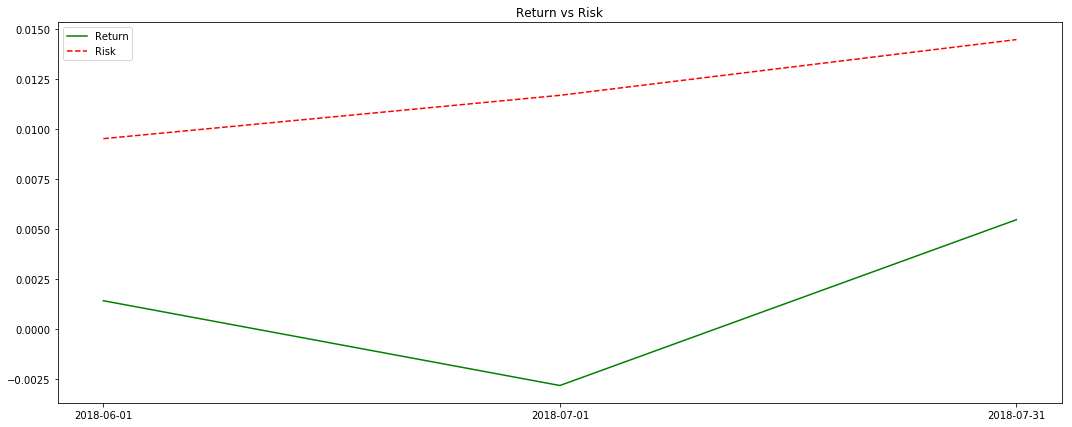

In [44]:
plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(stock_ts.index.values)) 
plt.plot(stock_ts['return'].values,label='Return',color='green')
plt.plot(stock_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Return vs Risk')
plt.legend(loc='upper left')
plt.show()

* *** Crypto optmization outcomes: Return vs Risk ***

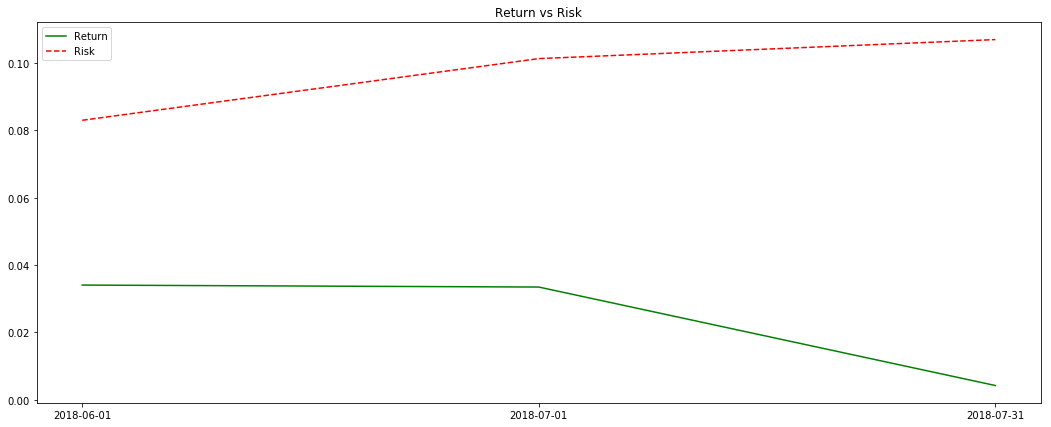

In [45]:
plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(ccur_ts.index.values)) 
plt.plot(ccur_ts['return'].values,label='Return',color='green')
plt.plot(ccur_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Return vs Risk')
plt.legend(loc='upper left')
plt.show()

* *** Mixed optmization outcomes: Return vs Risk ***

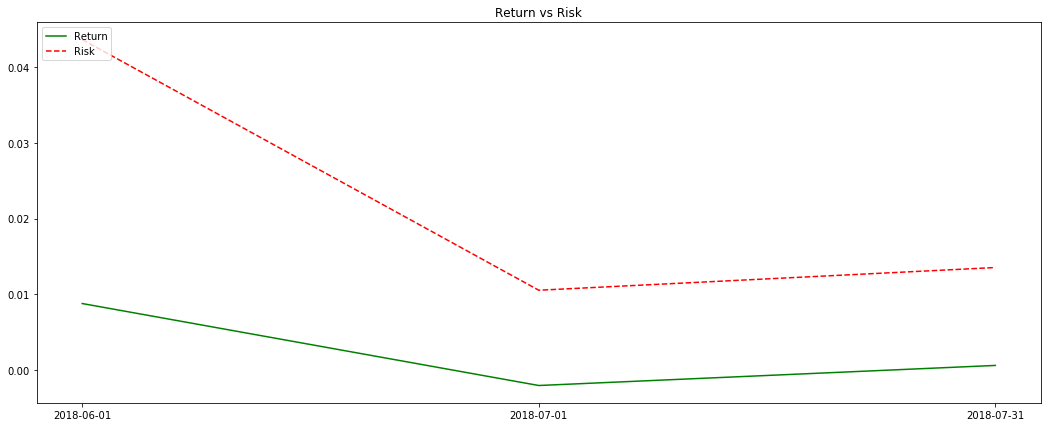

In [46]:
plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
plt.plot(mixed_ts['return'].values,label='Return',color='green')
plt.plot(mixed_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Return vs Risk')
plt.legend(loc='upper left')
plt.show()

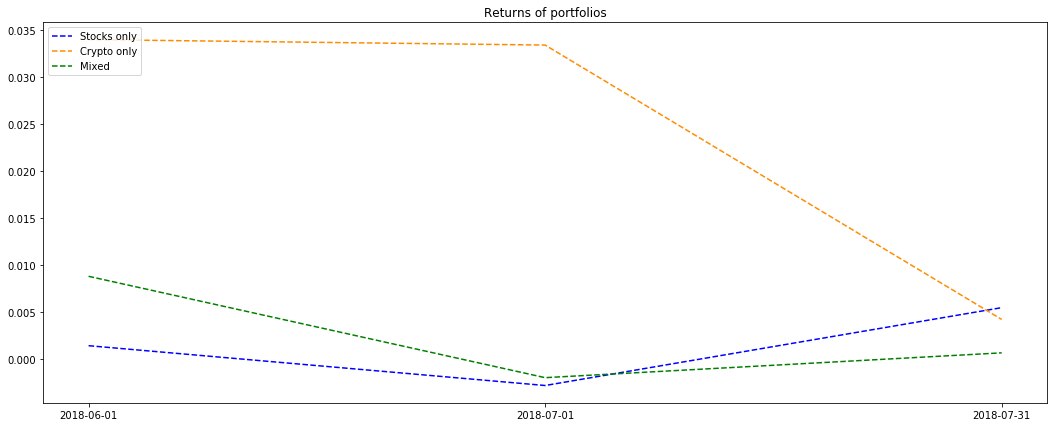

In [48]:
# All portfolios type return

plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
plt.plot(stock_ts['return'].values,'k--',label='Stocks only',color='blue')
plt.plot(ccur_ts['return'].values,'k--',label='Crypto only',color='darkorange')
plt.plot(mixed_ts['return'].values,'k--',label='Mixed',color='green')
plt.title('Returns of portfolios')
plt.legend(loc='upper left')
plt.show()

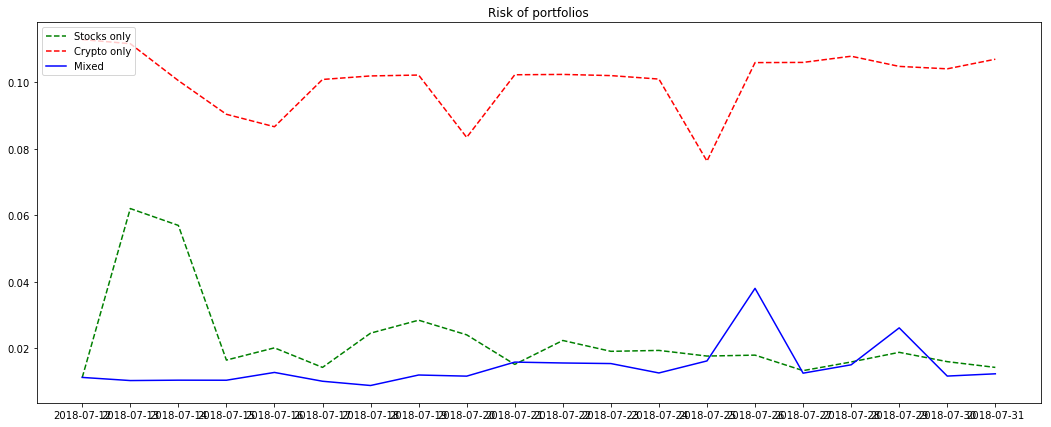

In [101]:
# All portfolios type Risk

plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
plt.plot(stock_ts['risk'].values,'k--',label='Stocks only',color='green')
plt.plot(ccur_ts['risk'].values,'k--',label='Crypto only',color='red')
plt.plot(mixed_ts['risk'].values,label='Mixed',color='blue')
plt.title('Risk of portfolios')
plt.legend(loc='upper left')
plt.show()

## Further outcome analysis

*** Temporal Aggregated Error and residual analysis ***

As the optimization takes place in specific days, the standard error of the estimate is defined as [David Longsteet]:

$$ Standard \ Error = \sqrt{\frac{\sum{{(\hat{Re} - Re)}^2}}{n-2}} $$




In [102]:
def get_errors(simulation_outcomes, returns_df, time_window = 30):
    substract_acum = 0
    predicted_returns, real_returns = list(), list()
    for date_index in simulation_outcomes.index:
        day = datetime.strptime(date_index, '%Y-%m-%d')
        # If the days checked are weekends, the friday before is considered instead
        test_date_index = date_index
        if day.weekday() == 5:
            test_date_index = (day + relativedelta(days = -1)).strftime('%Y-%m-%d')
        elif day.weekday() == 6:
            test_date_index = (day + relativedelta(days = -2)).strftime('%Y-%m-%d')

        # Holiday
        try:
            returns_df.loc[test_date_index]
        except:
            test_date_index = (datetime.strptime(test_date_index, '%Y-%m-%d') + relativedelta(days = -1)).strftime('%Y-%m-%d')
            
        real_return = returns_df.loc[test_date_index].dot(simulation_outcomes.loc[date_index]['weights'])
        predicted_return = simulation_outcomes.loc[date_index]['return']
        
        predicted_returns.append(predicted_return)
        real_returns.append(real_return)
        substract_acum += (np.subtract(predicted_return, real_return))**2
    
    std_error = np.sqrt(np.divide(substract_acum, time_window - 2))
    predicted_returns = pd.Series(predicted_returns)
    predicted_returns.index = simulation_outcomes.index
    real_returns = pd.Series(real_returns)
    real_returns.index = simulation_outcomes.index
    return std_error, predicted_returns, real_returns


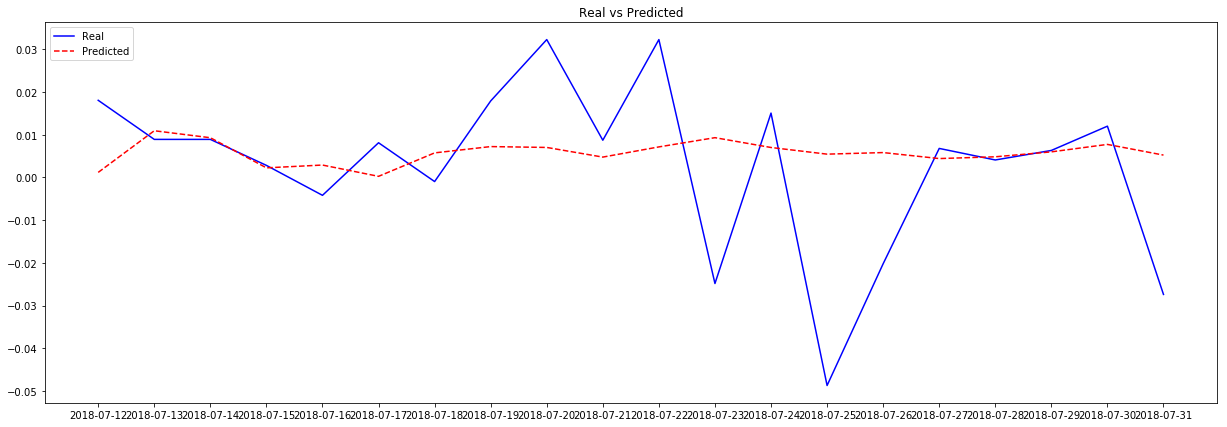

* Mean of predicted returns:  0.00573126958809
* Mean of real returns:  0.0028020764268
* Standard error of estimation:  0.0166697595216


In [103]:
# stocks
stock_std_error, stock_predicted_returns, stock_real_returns = get_errors(stock_ts, percent_stocks_returns, pre_fixed_time_window)

plt.figure(figsize=(21,7))
plt.xticks(range(num_iterations), list(stock_predicted_returns.index.values)) 
plt.plot(stock_real_returns.values,label='Real',color='blue')
plt.plot(stock_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Real vs Predicted')
plt.legend(loc='upper left')
plt.show()

print('* Mean of predicted returns: ', stock_predicted_returns.mean())
print('* Mean of real returns: ', stock_real_returns.mean())
print('* Standard error of estimation: ', stock_std_error)

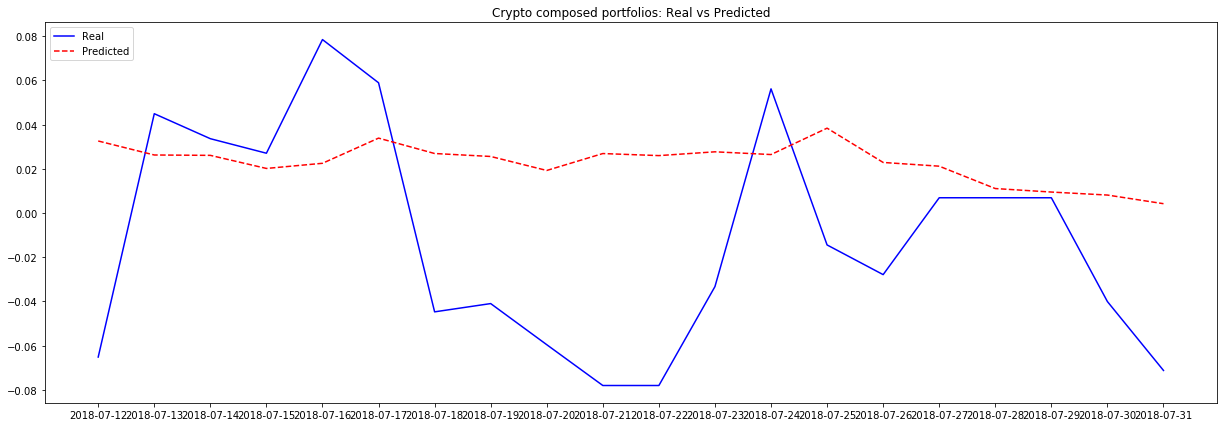

* Mean of predicted returns:  0.0227758761898
* Mean of real returns:  -0.0116861981973
* Standard error of estimation:  0.049860458321


In [104]:
# Crypto
crypto_std_error, ccurr_predicted_returns, ccurr_real_returns = get_errors(ccur_ts, percent_cripto_returns, pre_fixed_time_window)

plt.figure(figsize=(21,7))
plt.xticks(range(num_iterations), list(ccurr_predicted_returns.index.values)) 
plt.plot(ccurr_real_returns.values,label='Real',color='blue')
plt.plot(ccurr_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Crypto composed portfolios: Real vs Predicted')
plt.legend(loc='upper left')
plt.show()

print('* Mean of predicted returns: ', ccurr_predicted_returns.mean())
print('* Mean of real returns: ', ccurr_real_returns.mean())
print('* Standard error of estimation: ', crypto_std_error)

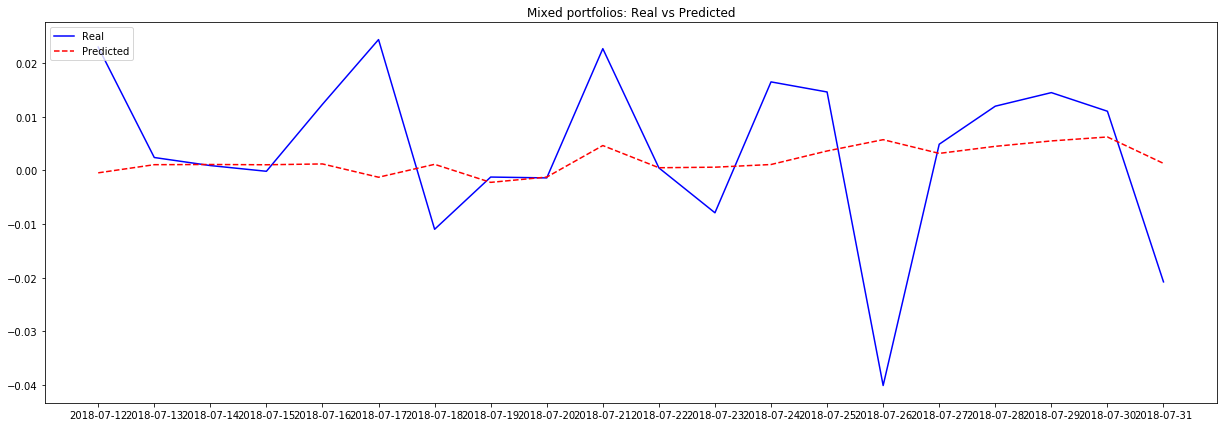

* Mean of predicted returns:  0.00184213867036
* Mean of real returns:  0.00383537219382
* Standard error of estimation:  0.0133408519801


In [105]:
# Mixed
mix_std_error, mix_predicted_returns, mix_real_returns = get_errors(mixed_ts, percent_returns_pd, pre_fixed_time_window)

plt.figure(figsize=(21,7))
plt.xticks(range(num_iterations), list(mix_predicted_returns.index.values)) 
plt.plot(mix_real_returns.values,label='Real',color='blue')
plt.plot(mix_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Mixed portfolios: Real vs Predicted')
plt.legend(loc='upper left')
plt.show()

print('* Mean of predicted returns: ', mix_predicted_returns.mean())
print('* Mean of real returns: ', mix_real_returns.mean())
print('* Standard error of estimation: ', mix_std_error)

*** Summarized return in time: real vs predicted ***

Using the outcomes of the simulations, it is possible to measure the aggregated profit  

In [91]:
def get_aggregated_profit_in_percent(returns):  
    ammount = 100
    for rate in returns.values:
        ammount += np.multiply(ammount, rate)
    return np.subtract(ammount, 100)

In [92]:
# stocks comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(stock_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(stock_real_returns)
print('Real aggregated profit using only stocks: ',aggregated_profit_r_return, "%")
print('Predicted aggregated profit using only stocks: ',aggregated_profit_p_return, '%')

Real aggregated profit using only stocks:  0.55178668748 %
Predicted aggregated profit using only stocks:  4.73853974673 %


In [93]:
# Crypto comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(ccurr_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(ccurr_real_returns)
print('Real aggregated profit (in percent) using only crypto: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using only crypto: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using only crypto:  -5.21435946997 %
Predicted aggregated profit (in percent) using only crypto:  21.3650083699 %


In [94]:
# mixed comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(mix_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(mix_real_returns)
print('Real aggregated profit (in percent) using mixed assets: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using mixed asset: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using mixed assets:  -27.5128875472 %
Predicted aggregated profit (in percent) using mixed asset:  7.01141159128 %


*** Mixed assets portfolio distribution of the outcome ***

Once the optimal portoflio has been calculated in each time period where the model ran, it is also desired to explore further whether the composition of mixed protfolios presents any pattern or not. This aims towards giving a basic insight about the optimal distribution of a portfolio of such type by knowing the percent of the capital destinated to stocks and to the criptocurrencies.   

In [146]:
num_stock_asset = len(percent_stocks_returns.columns)
num_cripto_assets = len(percent_cripto_returns.columns)

mixed_ts['percent_in_stocks'] = [100*sum(portfolio[0:num_stock_asset]) for portfolio in mixed_ts['weights']]
mixed_ts['percent_in_cripto'] = [100*sum(portfolio[num_stock_asset:num_stock_asset+num_cripto_assets]) for portfolio in mixed_ts['weights']]

mixed_ts['lag_in_days'] = mixed_ts.index

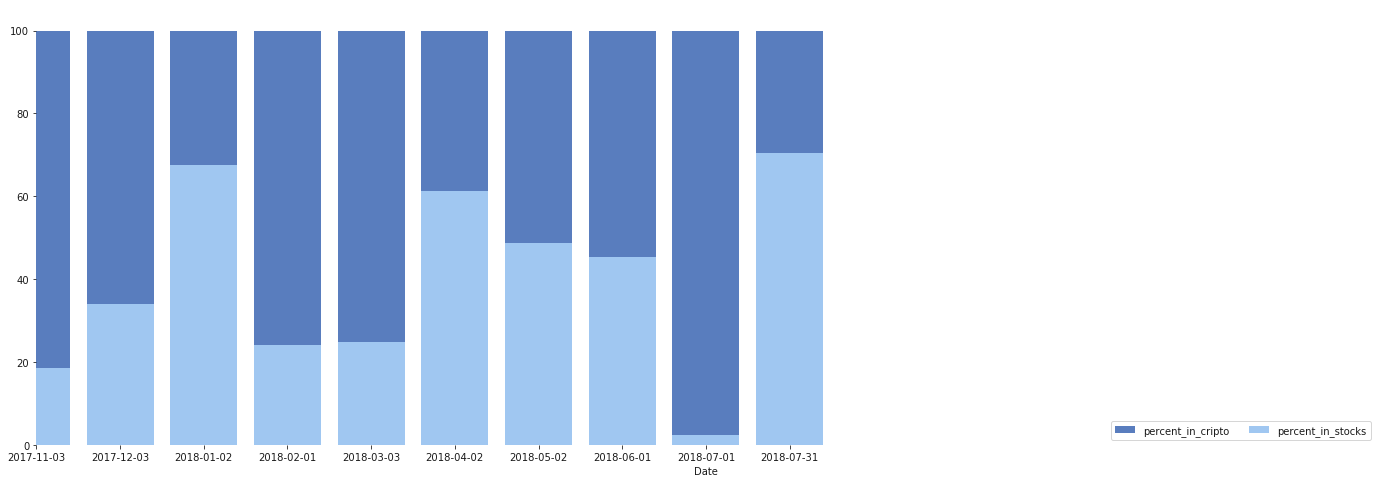

In [147]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(24, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Date")
sns.despine(left=True, bottom=True)

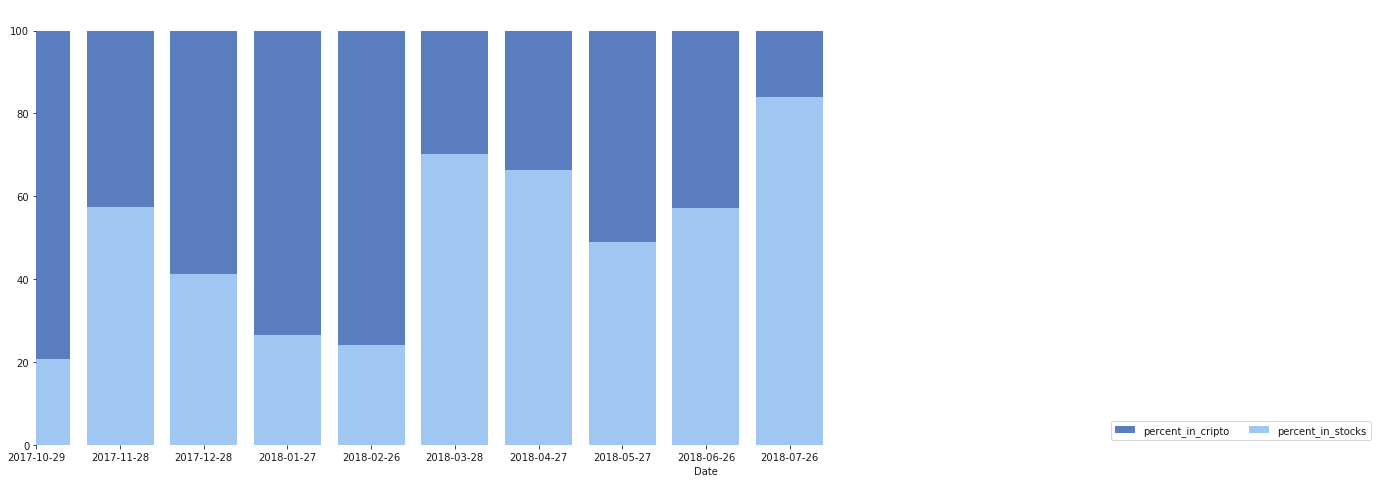

In [159]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(24, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Date")
sns.despine(left=True, bottom=True)

In [119]:
# Cleaning df
mixed_ts.drop(['temp_dim', 'lag_in_days'], axis = 1)

,return,risk,weights,portafolio_type,ratio_of_sharpe,percent_in_stocks,percent_in_cripto
2017-10-29,0.014109,0.072428,"[0.0, 0.206601082791, 0.0, 0.0, 0.0, 0.0, 0.0,...",mixed_assets,-0.388834,20.660108,79.339892
2017-11-28,0.012688,0.035447,"[0.117084679821, 0.105806764636, 0.0, 0.117084...",mixed_assets,-0.967861,57.414548,42.585452
2017-12-28,0.005428,0.035924,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37128664...",mixed_assets,-0.573023,41.340576,58.659424
2018-01-27,0.016053,0.047636,"[0.0, 0.0, 0.0, 0.0143221793986, 0.0, 0.245192...",mixed_assets,-0.437239,26.442362,73.557638
2018-02-26,0.046650,0.073712,"[0.0, 0.0876858915059, 0.0441539121685, 0.0, 0...",mixed_assets,-0.466182,24.201096,75.798904
2018-03-28,0.005721,0.033453,"[0.146304273815, 0.0, 0.148858309009, 0.0, 0.0...",mixed_assets,-0.826326,70.228338,29.771662
2018-04-27,0.002393,0.030975,"[0.221208011422, 0.221208011422, 0.0, 0.221208...",mixed_assets,-0.917063,66.362403,33.637597
2018-05-27,0.016430,0.046022,"[0.0, 0.0, 0.0, 0.0, 0.400033778758, 0.0, 0.0,...",mixed_assets,-0.468035,48.927573,51.072427
2018-06-26,-0.007762,0.019219,"[0.142857142857, 0.0, 0.0, 0.0, 0.142857142857...",mixed_assets,-0.909994,57.142857,42.857143
2018-07-26,0.006633,0.016167,"[0.0, 0.259378578447, 0.0, 0.253898422967, 0.0...",mixed_assets,-1.318795,83.912553,16.087447


# TO DO:

* Clean data, at least for criptocurrencies with few tracking history registers. [OK]
* Fix when a big amount of past data is considered when performing optmizations [OK]
* Select most valuable assets of Bovespa [OK - But considering the state in Marxh Only]
* Demonstrate variation between cotations in real and dolar - Not relevant because a differianted series is taken.
* Calculate the mixed portfolios distribution in 3 stages:
    * Ratio of sharpe
    * Max. return
    * Min. Risk
    
* Real error analysis (Mean - retorno real) for normal AVG - and AVG [OK]
* GARCH models, calculate the return of a single asset, this will minimize the error.
* Calculate the real return after calculating all optimized portfolios within the defined time interval.

# Improvements and future work

* Based on the work developed by Alberto Blanco Garcés (@alberduris github user), predicting either stocks and cryptocurrencies prices using RNN or recurrent neural networks, offer appareantly good results in the forecasts. Test this approach instead of GARCH. precision and time-complexity in execution also.